#Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Aus_grocery_synthetic_dataset2.csv')
df.head()

,Category,Sub_category,Product_Group,Product_Name,Brand,Sku,RunDate,unit_price_x
0,Meat & seafood,Poultry,Chicken offal,RSPCA Approved Chicken Necks,Coles,1491280P,11/9/2022,6.50
1,Meat & seafood,Poultry,Chicken offal,RSPCA Approved Chicken Livers,Coles,1718058P,11/9/2022,9.00
2,Meat & seafood,Poultry,Chicken offal,RSPCA Approved Chicken Giblets,Coles,2565429P,11/9/2022,7.50
3,Meat & seafood,Poultry,Chicken offal,RSPCA Approved Chicken Frames,Coles,3199541P,11/9/2022,4.50
4,Meat & seafood,Poultry,Crumbed chicken,RSPCA Chicken Schnitzel Plain Crumb,Coles,2904193P,11/9/2022,8.75


##Removing all rows whose "unit_price_x value is either "0" or "NaN".

In [2]:
df = df[(df['unit_price_x'] != 0) & (df['unit_price_x'].notna())]

#Transfering date column type to "DateTimeObject"

In [3]:
def parse_mixed_dates(date):
    try:
        # Attempt parsing as MM/DD/YYYY
        return pd.to_datetime(date, format='%m/%d/%Y')
    except ValueError:
        try:
            # Attempt parsing as DD/MM/YYYY
            return pd.to_datetime(date, format='%d/%m/%Y')
        except ValueError:
            return pd.NaT  # Return NaT if both fail

# Apply the function to parse mixed formats
df['RunDate_parsed'] = df['RunDate'].apply(parse_mixed_dates)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187072 entries, 0 to 187195
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Category        187072 non-null  object        
 1   Sub_category    187072 non-null  object        
 2   Product_Group   187072 non-null  object        
 3   Product_Name    187072 non-null  object        
 4   Brand           187072 non-null  object        
 5   Sku             187072 non-null  object        
 6   RunDate         187072 non-null  object        
 7   unit_price_x    187072 non-null  float64       
 8   RunDate_parsed  187072 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 14.3+ MB


In [5]:
print(df.describe())

        unit_price_x                 RunDate_parsed
count  187072.000000                         187072
mean        8.537730  2020-08-02 16:01:26.058843392
min         0.010000            2020-01-01 00:00:00
25%         1.320000            2020-04-05 00:00:00
50%         3.050000            2020-07-08 00:00:00
75%         7.120000            2020-10-11 00:00:00
max       337.830000            2023-01-17 00:00:00
std        15.779829                            NaN


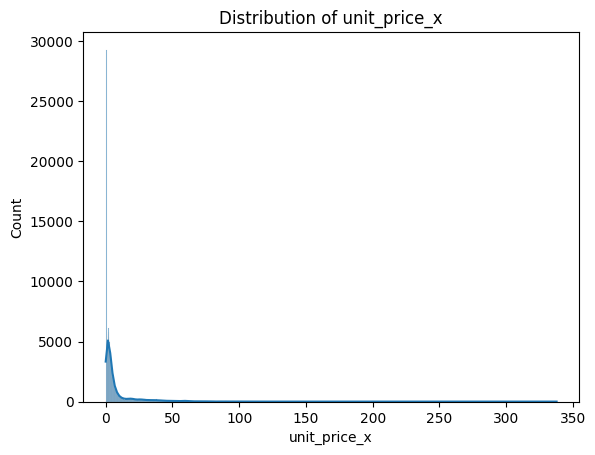

In [6]:
# Plot for unit_price_x
sns.histplot(df['unit_price_x'], kde=True)
plt.title('Distribution of unit_price_x')
plt.show()


##Normaliz the "unit_price_x" column

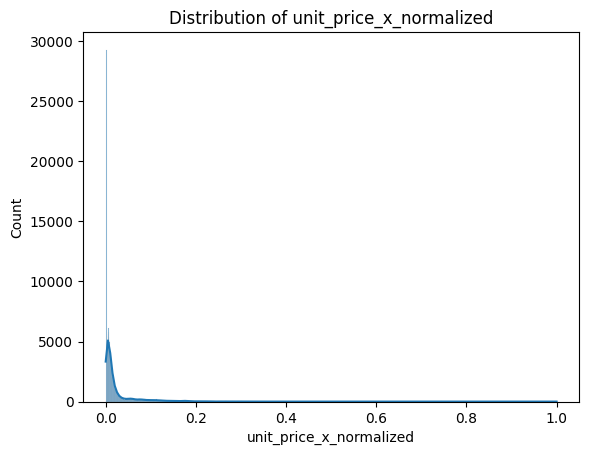

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the unit_price_x column
df['unit_price_x_normalized'] = scaler.fit_transform(df[['unit_price_x']])

# Check the result
# Plot for unit_price_x
sns.histplot(df['unit_price_x_normalized'], kde=True)
plt.title('Distribution of unit_price_x_normalized')
plt.show()


##LSTM Model for price prediction

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4677/4677 - 22s - 5ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2/20
4677/4677 - 17s - 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/20
4677/4677 - 21s - 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/20
4677/4677 - 19s - 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/20
4677/4677 - 22s - 5ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/20
4677/4677 - 19s - 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/20
4677/4677 - 20s - 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/20
4677/4677 - 27s - 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/20
4677/4677 - 36s - 8ms/step - loss: 0.0022 - val_loss: 0.0023
4677/4677 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Absolute Error (MAE): 9.109879946949945
Mean Squared Error (MSE): 257.67459061597555
Root Mean Squared Error (RMSE): 16.05224565647983
R-Squared: -0.0007045055238354969


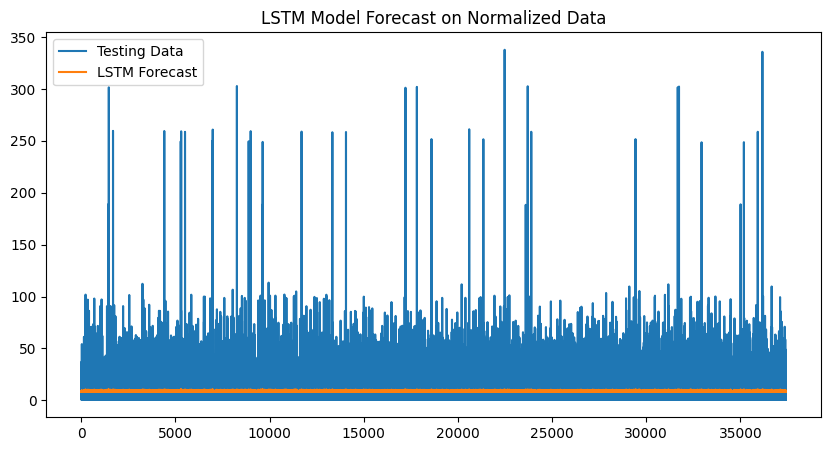

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

price_data = df['unit_price_x_normalized'].values

# Split data into training and testing
train_size = int(len(price_data) * 0.8)
train, test = price_data[:train_size], price_data[train_size:]

# Create the dataset matrix
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate performance metrics
mae = mean_absolute_error(y_test[0], test_predict[:,0])
mse = mean_squared_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
r2 = r2_score(y_test[0], test_predict[:,0])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared: {r2}")

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(y_test[0], label='Testing Data')
plt.plot(test_predict[:,0], label='LSTM Forecast')
plt.legend(loc='best')
plt.title('LSTM Model Forecast on Normalized Data')
plt.show()


In [9]:
import pickle
with open('LSTM_model_MinMax_normalization.pkl', 'wb') as pkl:
  pickle.dump(model, pkl)